# Irony Detection in English - Task 2

#### The goal of this task is to create a classifier capable of classifing different types of irony

Like the task one that in this [notebook](Irony_Detection_in_English_Tweets.ipynb) we explore with more detail.

### The Dataset

* The dataset used for this task contains the same tweets from the one used in the task 1, but label in a different way

Furthermore we decide to use the data in a different way from the one in the task 1. Instead of using the split in train and test made by the organization we will manipulate the data and try two scenarios in order to use the scikit learn model split function and K-Folds cross validation:

1. Use the train dataset alone
2. Join the train and test datasets making sure they remain balanced

This classification task is not binary as the first one. This task is a multiclass problem. In this task the labels have the following meaning:

0. Non-ironic
1. Ironic by clash
2. Situational irony
3. Other irony
**From this two scenarios, we will choose the one that performs better in a preliminary analyses**

In [ ]:
from IPython.display import display, HTML
import pandas
import numpy

train_data=pandas.read_csv('data/task2/train.csv',  delimiter = '\t', quoting = 3, encoding="utf-8")
all_data=pandas.read_csv('data/task2/all.csv', delimiter = '\t', quoting = 3, encoding="utf-8")

In [ ]:
train_data.head()

In [ ]:
all_data.head()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

train_data.groupby('label').size().plot.bar()

In [ ]:
all_data.groupby('label').size().plot.bar()

#### Different from the task 1 the dataset is pretty much unbalanced towards the inexistance of irony in the tweets

This fact could introduced bias in the classficator. This way special attention to the fenomena of overfitting must be taken into account

### Cross Validation to Check which solution is the best

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

corpus_test=pre_processing_pipeline(train_data)

X , y, X_train,y_train,X_test,y_test=refresh_data(corpus_test,train_data['label'])

classifier=GaussianNB()

scores=cross_val_score(classifier,X,y,cv=10,scoring='accuracy')

print(scores.mean())

In [ ]:
corpus_all=pre_processing_pipeline(all_data)

X , y, X_train,y_train,X_test,y_test=refresh_data(corpus_all,all_data['label'])

classifier=GaussianNB()

scores=cross_val_score(classifier,X,y,cv=10,scoring='accuracy')

print(scores.mean())

#### From this results we can infere that use only the training set will produce better results.

### Handle the Unbalanced Dataset

We will try how the same Naive Bayes model would perform with after applying sampling techniques in order to balance the dataset

In [56]:
from sklearn.utils import resample
from IPython.display import display, HTML
import pandas
import numpy

train_data=pandas.read_csv('data/task2/train.csv',  delimiter = '\t', quoting = 3, encoding="utf-8")

df_majority=train_data[train_data.label==0]
df_minority_1=train_data[train_data.label==1]
df_minority_2=train_data[train_data.label==2]
df_minority_3=train_data[train_data.label==3]

df_minority_1_upsampled = resample(df_minority_1,replace=True,n_samples=1900,random_state=123)
df_minority_2_upsampled = resample(df_minority_2,replace=True,n_samples=1900,random_state=123)
df_minority_3_upsampled = resample(df_minority_3,replace=True,n_samples=1900,random_state=123)

train_data=pandas.concat([df_majority,df_minority_1_upsampled,df_minority_2_upsampled,df_minority_3_upsampled],ignore_index=True)

<AxesSubplot:xlabel='label'>

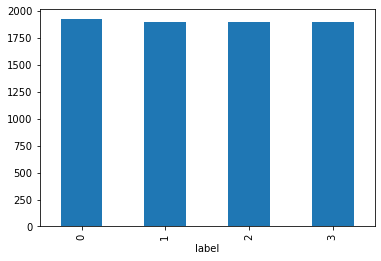

In [57]:
train_data.groupby('label').size().plot.bar()

In [58]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

corpus=pre_processing_pipeline(train_data)

X , y, X_train,y_train,X_test,y_test=refresh_data(corpus,train_data['label'])

classifier=GaussianNB()

scores=cross_val_score(classifier,X,y,cv=10,scoring='accuracy')

print(scores.mean())

0.5960856957100547


##### Helper Functions

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
import emoji
import re
import contractions
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


def pre_processing_pipeline(dataframe):
    dataframe['tweet'].str.replace('http\S+|www.\S+', '', case=False)
    dataframe['tweet'].str.replace('@\S+', '', case=False)
    dataframe['tweet'].str.replace('\d+', '', case=False)
    dataframe['tweet'].str.replace('#', '', case=False)
    
    emoji_result=[]

    for i in range(len(dataframe)):    
        demojize_result=emoji.demojize(dataframe.loc[i,'tweet'])
        #Remove the ":" from the convertion made by emoji
        demojize_result=re.sub(":", " ", demojize_result)
        demojize_result=re.sub("_", " ", demojize_result)
        demojize_result=re.sub("-", " ", demojize_result)
        emoji_result.append(demojize_result)


    dummy=[]
    for i in range(len(emoji_result)):
        dummy.append(contractions.fix(emoji_result[i]))

    from nltk.stem import WordNetLemmatizer

    lemmatizer = WordNetLemmatizer()

    lemmatization_result = []

    for i in range(len(dummy)):
        tweet = lemmatizer.lemmatize(dummy[i])
        lemmatization_result.append(tweet)

    ps = PorterStemmer()
    corpus = []

    for i in range(len(lemmatization_result)):
        # get review and remove non alpha chars
        tweet = re.sub('[^\w_\w]', ' ', lemmatization_result[i])
        # to lower-case and tokenize
        tweet = tweet.lower().split()
        # stemming and stop word removal
        tweet = ' '.join([ps.stem(w) for w in tweet if not w in set(stopwords.words('english'))])
        corpus.append(tweet)

    return corpus

In [32]:
from sklearn.model_selection import train_test_split

def refresh_data(X,y):
    vectorizer = TfidfVectorizer(max_features = 800)

    X=vectorizer.fit_transform(X).toarray()
    y=y.copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
    
    
    return (X , y, X_train,y_train,X_test,y_test)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score


def print_stats():
    
    print(classification_report(y_test,y_predicted))
    print(confusion_matrix(y_test, y_predicted))
    accuracy_value=accuracy_score(y_test,y_predicted)
    precision_value=precision_score(y_test,y_predicted,average='weighted')
    f1_value=f1_score(y_test,y_predicted,average='weighted')

    actual_conclusion=pandas.DataFrame(
        {
        'Our Results':[accuracy_value,precision_value,f1_value],
        'Winners Result':[0.7347,0.6304,0.8006]
        } , index=['Accuracy','Precision','F1-Value'])

    print(actual_conclusion.head())